In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 80

ng =8

ng_adju = (/ 2 /) 

ng_refs = (/ 2 , 6 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 10 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6 , 1.66/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5 , 0.5/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

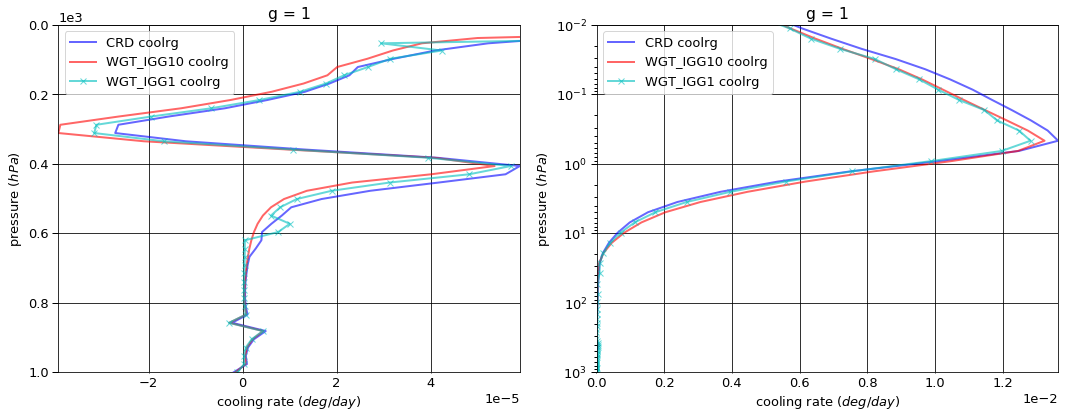

# Figure: cooling rate g-group 2

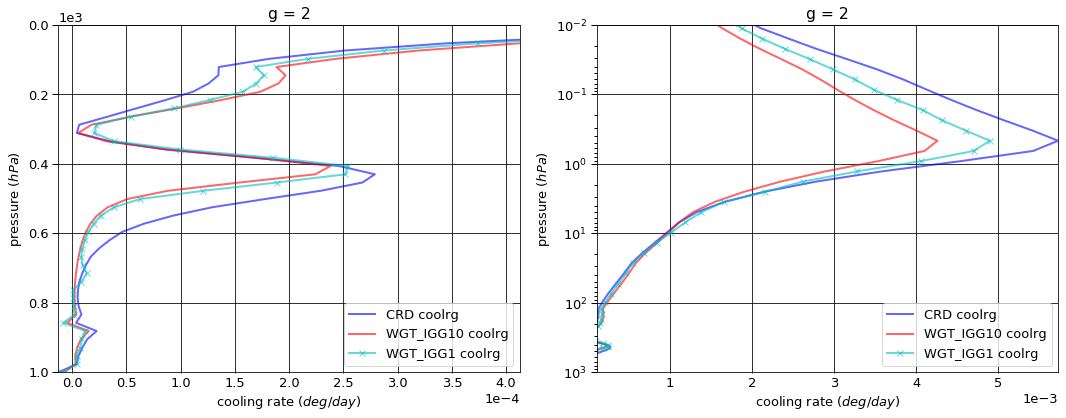

# Figure: cooling rate g-group 3

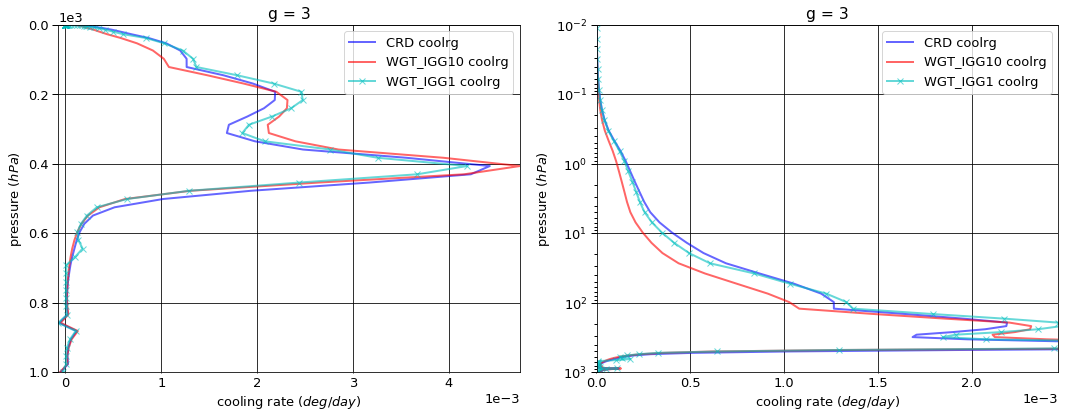

# Figure: cooling rate g-group 4

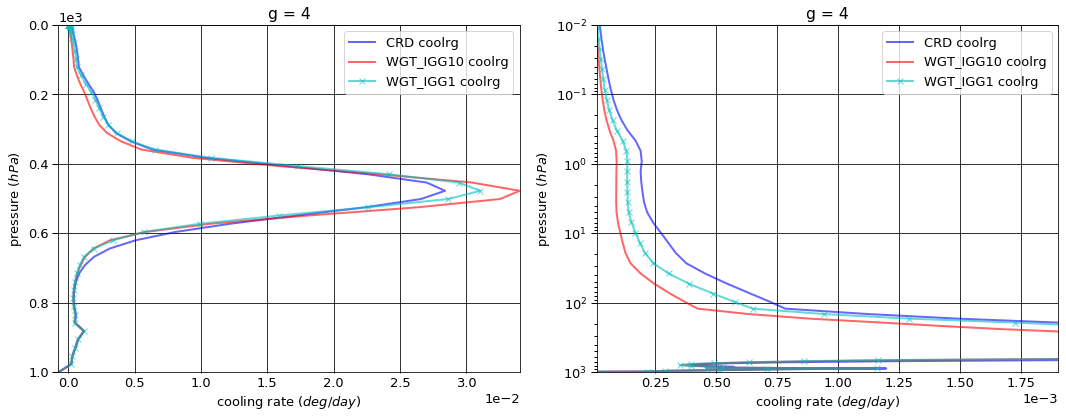

# Figure: cooling rate g-group 5

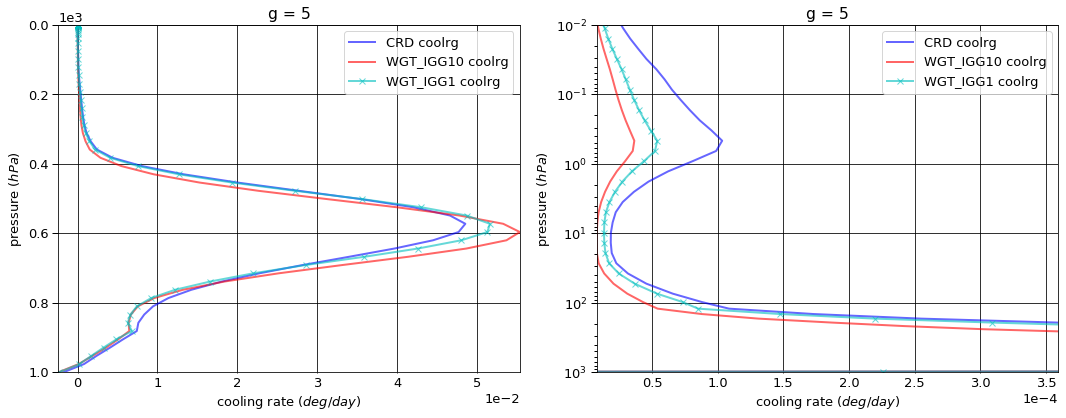

# Figure: cooling rate g-group 6

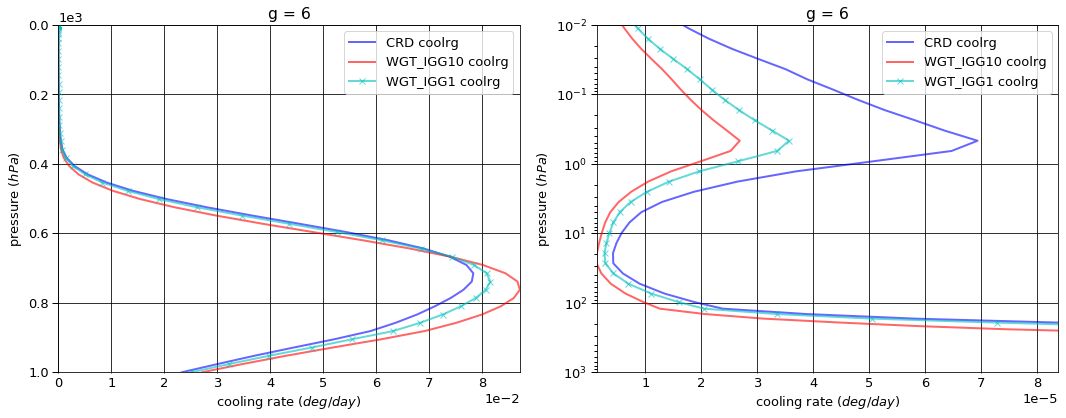

# Figure: cooling rate g-group 7

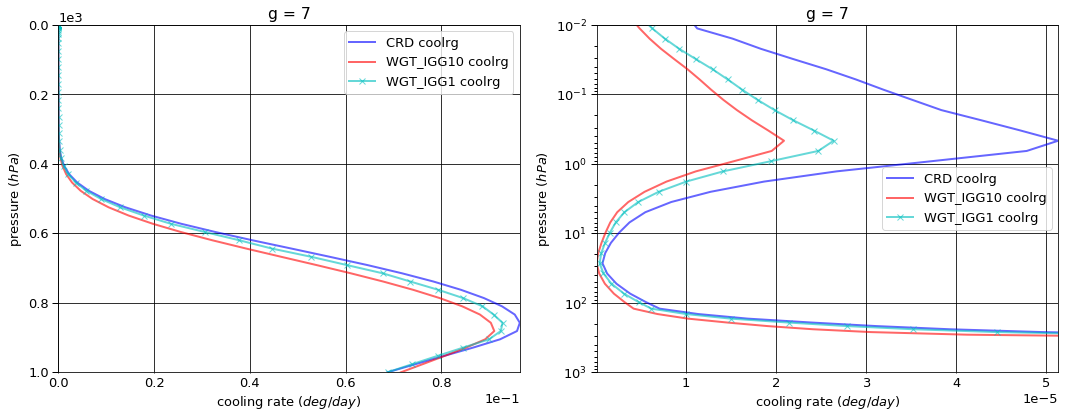

# Figure: cooling rate g-group 8

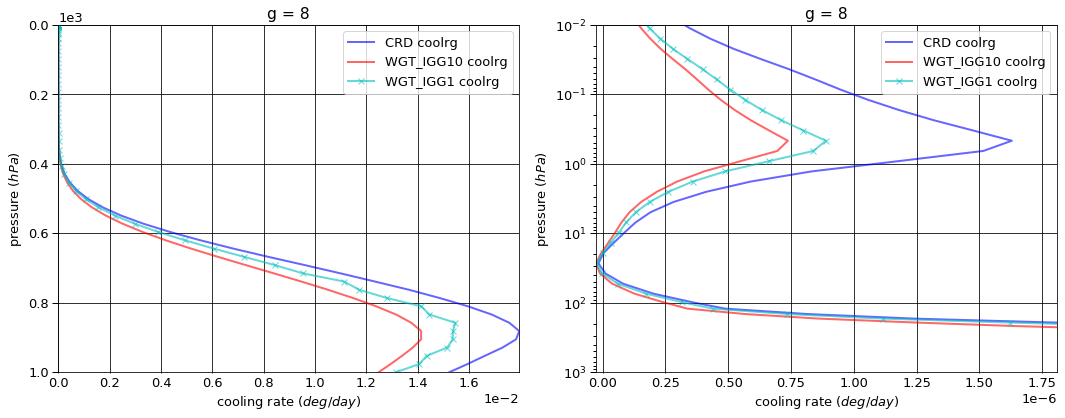

# Figure: cooling rate g-group total

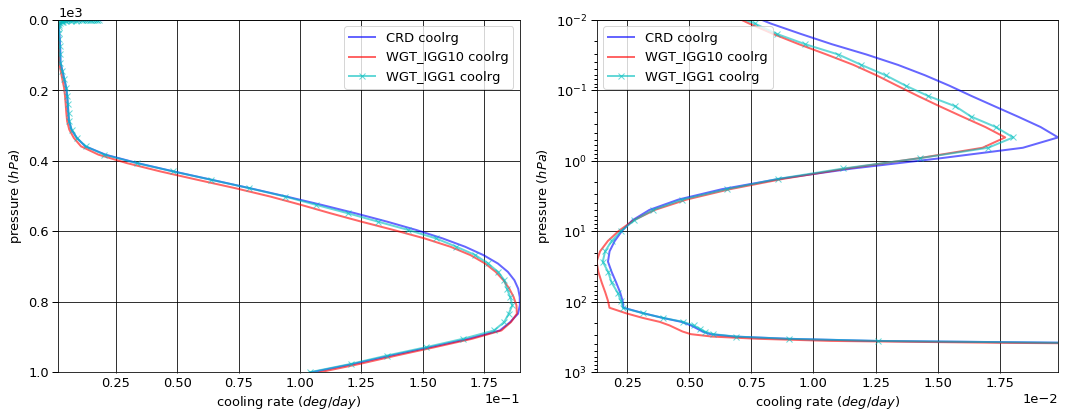

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.005482  0.000000  -0.005482
  1013.0   76     -0.008585  0.008593   0.000007
2 0.0      1      -0.014071  0.000000  -0.014071
  1013.0   76     -0.023974  0.024030   0.000056
3 0.0      1      -0.128097  0.000000  -0.128097
  1013.0   76     -0.216867  0.217067   0.000199
4 0.0      1      -0.676232  0.000000  -0.676232
  1013.0   76     -0.955900  0.958972   0.003072
5 0.0      1      -1.560984  0.000000  -1.560984
  1013.0   76     -1.867226  1.881263   0.014037
6 0.0      1      -4.165526  0.000000  -4.165526
  1013.0   76     -4.419700  3.796474  -0.623227
7 0.0      1     -10.574544  0.000000 -10.574544
  1013.0   76    -10.709404  4.172805  -6.536599
8 0.0      1      -5.373094  0.000000  -5.373094
  1013.0   76     -5.389482  0.714896  -4.674586


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.005477  0.000000  -0.005477
  1013.0   76     -0.008585  0.008591   0.000005
2 0.0      1      -0.013300  0.000000  -0.013300
  1013.0   76     -0.023974  0.024000   0.000027
3 0.0      1      -0.126728  0.000000  -0.126728
  1013.0   76     -0.216867  0.217073   0.000206
4 0.0      1      -0.682000  0.000000  -0.682000
  1013.0   76     -0.955900  0.958816   0.002916
5 0.0      1      -1.578382  0.000000  -1.578382
  1013.0   76     -1.867226  1.885755   0.018529
6 0.0      1      -4.201366  0.000000  -4.201366
  1013.0   76     -4.419700  3.952508  -0.467192
7 0.0      1     -10.609095  0.000000 -10.609095
  1013.0   76    -10.709404  3.761659  -6.947745
8 0.0      1      -5.377162  0.000000  -5.377162
  1013.0   76     -5.389482  0.558855  -4.830627


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.005438  0.000000  -0.005438
  1013.0   76     -0.008585  0.008589   0.000004
2 0.0      1      -0.013476  0.000000  -0.013476
  1013.0   76     -0.023974  0.024009   0.000035
3 0.0      1      -0.125654  0.000000  -0.125654
  1013.0   76     -0.216867  0.216962   0.000094
4 0.0      1      -0.671185  0.000000  -0.671185
  1013.0   76     -0.955900  0.958796   0.002896
5 0.0      1      -1.556842  0.000000  -1.556842
  1013.0   76     -1.867226  1.884341   0.017115
6 0.0      1      -4.174593  0.000000  -4.174593
  1013.0   76     -4.419700  3.886545  -0.533156
7 0.0      1     -10.585605  0.000000 -10.585605
  1013.0   76    -10.709404  3.981754  -6.727650
8 0.0      1      -5.374475  0.000000  -5.374475
  1013.0   76     -5.389482  0.625152  -4.764329


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000005  0.000000  0.000005
  1013.0   76     0.000000 -0.000002 -0.000002
2 0.0      1      0.000771  0.000000  0.000771
  1013.0   76     0.000000 -0.000030 -0.000030
3 0.0      1      0.001369  0.000000  0.001369
  1013.0   76     0.000000  0.000007  0.000007
4 0.0      1     -0.005768  0.000000 -0.005768
  1013.0   76     0.000000 -0.000156 -0.000156
5 0.0      1     -0.017398  0.000000 -0.017398
  1013.0   76     0.000000  0.004492  0.004492
6 0.0      1     -0.035840  0.000000 -0.035840
  1013.0   76     0.000000  0.156035  0.156035
7 0.0      1     -0.034551  0.000000 -0.034551
  1013.0   76     0.000000 -0.411146 -0.411146
8 0.0      1     -0.004068  0.000000 -0.004068
  1013.0   76     0.000000 -0.156041 -0.156041


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000044  0.000000  0.000044
  1013.0   76     0.000000 -0.000004 -0.000004
2 0.0      1      0.000594  0.000000  0.000594
  1013.0   76     0.000000 -0.000021 -0.000021
3 0.0      1      0.002443  0.000000  0.002443
  1013.0   76     0.000000 -0.000105 -0.000105
4 0.0      1      0.005047  0.000000  0.005047
  1013.0   76     0.000000 -0.000176 -0.000176
5 0.0      1      0.004142  0.000000  0.004142
  1013.0   76     0.000000  0.003078  0.003078
6 0.0      1     -0.009067  0.000000 -0.009067
  1013.0   76     0.000000  0.090071  0.090071
7 0.0      1     -0.011061  0.000000 -0.011061
  1013.0   76     0.000000 -0.191051 -0.191051
8 0.0      1     -0.001381  0.000000 -0.001381
  1013.0   76     0.000000 -0.089744 -0.089744

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.432391e-03
  1001.112500 75    -1.899019e-06
2 0.000312    1      5.620524e-04
  1001.112500 75    -1.282927e-05
3 0.000312    1      1.216050e-08
  1001.112500 75    -5.119370e-05
4 0.000312    1      4.692088e-06
  1001.112500 75    -7.601346e-04
5 0.000312    1      4.298084e-06
  1001.112500 75    -1.772970e-03
6 0.000312    1      1.915276e-06
  1001.112500 75     2.329729e-02
7 0.000312    1      2.258253e-07
  1001.112500 75     6.875332e-02
8 0.000312    1     -1.697953e-08
  1001.112500 75     1.522584e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.622215e-03
  1001.112500 75    -1.479453e-06
2 0.000312    1      5.059793e-04
  1001.112500 75    -7.338932e-06
3 0.000312    1      7.874721e-09
  1001.112500 75    -5.704370e-05
4 0.000312    1      1.829103e-06
  1001.112500 75    -7.637249e-04
5 0.000312    1      1.023185e-06
  1001.112500 75    -2.404791e-03
6 0.000312    1      1.826560e-07
  1001.112500 75     2.711765e-02
7 0.000312    1     -1.089139e-07
  1001.112500 75     7.156222e-02
8 0.000312    1     -1.041107e-08
  1001.112500 75     1.247818e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.423275e-03
  1001.112500 75    -1.087995e-06
2 0.000312    1      5.613330e-04
  1001.112500 75    -9.682661e-06
3 0.000312    1      1.118447e-08
  1001.112500 75    -2.745467e-05
4 0.000312    1      3.018187e-06
  1001.112500 75    -7.577140e-04
5 0.000312    1      1.972342e-06
  1001.112500 75    -2.305860e-03
6 0.000312    1      5.538640e-07
  1001.112500 75     2.507437e-02
7 0.000312    1     -4.683179e-09
  1001.112500 75     6.876964e-02
8 0.000312    1     -1.089139e-08
  1001.112500 75     1.315226e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.898246e-04
  1001.112500 75     4.195654e-07
2 0.000312    1     -5.607310e-05
  1001.112500 75     5.490338e-06
3 0.000312    1     -4.285784e-09
  1001.112500 75    -5.849994e-06
4 0.000312    1     -2.862985e-06
  1001.112500 75    -3.590400e-06
5 0.000312    1     -3.274899e-06
  1001.112500 75    -6.318203e-04
6 0.000312    1     -1.732620e-06
  1001.112500 75     3.820360e-03
7 0.000312    1     -3.347392e-07
  1001.112500 75     2.808900e-03
8 0.000312    1      6.568458e-09
  1001.112500 75    -2.747655e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -9.116200e-06
  1001.112500 75     8.110235e-07
2 0.000312    1     -7.194100e-07
  1001.112500 75     3.146609e-06
3 0.000312    1     -9.760370e-10
  1001.112500 75     2.373903e-05
4 0.000312    1     -1.673900e-06
  1001.112500 75     2.420500e-06
5 0.000312    1     -2.325742e-06
  1001.112500 75    -5.328899e-04
6 0.000312    1     -1.361412e-06
  1001.112500 75     1.777084e-03
7 0.000312    1     -2.305085e-07
  1001.112500 75     1.632800e-05
8 0.000312    1      6.088132e-09
  1001.112500 75    -2.073577e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.498029,0.000000,-22.498029
1013.0,76,-23.591138,11.774099,-11.817039



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.593510,0.000000,-22.59351
1013.0,76,-23.591138,11.367257,-12.22388



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-22.507268,0.000000,-22.507268
1013.0,76,-23.591138,11.586147,-12.004991



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.09548,0.000000,-0.095480
1013.0,76,0.00000,-0.406842,-0.406841



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.009239,0.000000,-0.009239
1013.0,76,0.000000,-0.187952,-0.187952


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.002006
1001.112500,75,0.104677



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.002131
1001.112500,75,0.107924



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.001990
1001.112500,75,0.103894



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000126
1001.112500,75,0.003246



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000015
1001.112500,75,-0.000783


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000362,0.000364
2,0.001012,0.001017
3,0.009150,0.009201
4,0.040363,0.040552
5,0.078812,0.079224
6,0.186500,0.187529
7,0.453062,0.454145
8,0.230738,0.227968


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.880119e-19
2,3.156120e-20
3,5.920606e-21
4,1.079701e-21
5,1.968977e-22
6,3.590689e-23
7,6.548096e-24
8,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.880119e-19,NaN,0.000362,0.000364,0.000362,0.000364,10.0
2,3.156120e-20,0.167868,0.001012,0.001017,0.001375,0.001381,10.0
3,5.920606e-21,0.187591,0.009150,0.009201,0.010525,0.010583,600.0
4,1.079701e-21,0.182363,0.040363,0.040552,0.050888,0.051134,600.0
5,1.968977e-22,0.182363,0.078812,0.079224,0.129700,0.130358,600.0
6,3.590689e-23,0.182363,0.186500,0.187529,0.316200,0.317887,600.0
7,6.548096e-24,0.182363,0.453062,0.454145,0.769262,0.772032,600.0
8,1.194132e-24,0.182363,0.230738,0.227968,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
